In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

# Reward Trace
This tutorial shows how a reward signal influnces a learning enabled connection between two neurons. The reward axon ID starts at address 4096, so if the reward signal is sent through SNIPs, the offset 4096 should be added on top of the corresponding reward register address.

In [2]:
import nxsdk.api.n2a as nx
import matplotlib.pyplot as plt

## Network Architecture

The following is an illustration of the network used in the tutorial:
![Reward Trace](figures/jupyter_reward_trace.png)

In the above diagram, there are three neurons: Compartment 1(c1), Compartment 2(c2) and Compartment 3(c3). C1 fires immedieately when Reward Spikes Generator sends a spike, then propogate the reward signal to the learning enabled connection between c2 and c3. The propagation of the reward signal is passed through the reinforcement Channel that is embedded in the Learning Rule defined between c2 and c3.   
## Setup and Configure Network

In [3]:
net = nx.NxNet()

### Setup Compartment Prototypes

Compartment parameters are defined as follows:
- vThMant: Actual numerical threshold is 150*(2^6) = 9600.

In [4]:
pbasic = nx.CompartmentPrototype(vThMant=150,
                                 compartmentCurrentDecay=3276,
                                 compartmentVoltageDecay=3276)

### Setup Learning Rule and Connection Prototypes
A basic learning rule used for weight $w$ variable is given by: $dw=u_0\cdot r_1$, where the synaptic weight is adjusted on the existence of a reinforcement signal.
There are two types of connecton used in this tutorial: Reward Connection without learning and Connecton 2 to 3 with learning.

In [5]:
lr = net.createLearningRule(dw='u0*r1',
                            x1Impulse=40,
                            x1TimeConstant=4,
                            y1Impulse=40,
                            y1TimeConstant=4,
                            r1Impulse=20,
                            r1TimeConstant=4,
                            tEpoch=2)

connProto0 = nx.ConnectionPrototype(weight=50, enableLearning=1,
                                    learningRule=lr,numTagBits=8,
                                    signMode=nx.SYNAPSE_SIGN_MODE.MIXED)

connProto1 = nx.ConnectionPrototype(weight=200, numTagBits=8)

### Create Compartments and Connections

In [6]:
# Create Compartments
c1 = net.createCompartment(pbasic)
c2 = net.createCompartment(pbasic)
c3 = net.createCompartment(pbasic)

# Create Connections
conn23 = c2.connect(c3, connProto0)

### Create and Connect Spike Generators

In [7]:
numPorts = 1

# Reward spike at 26
rewardTime = [26]
spikeGenReward = net.createSpikeGenProcess(numPorts)
spikeGenReward.addSpikes([0], [rewardTime])
connRewardSpikeToC1 = spikeGenReward.connect(c1, prototype=connProto1)
connC1ToLrnRule = c1.connect(lr.reinforcementChannel, prototype=connProto0)

## Configure Probes

Probe the behavior of compartment 1 (c1), the learning connection (conn23), and the reward connection.

In [8]:
c1Probes = c1.probe([nx.ProbeParameter.SPIKE])

conn23PrbSyn = conn23.probe([nx.ProbeParameter.SYNAPSE_WEIGHT])

rewardProbe = connC1ToLrnRule.probe([nx.ProbeParameter.REWARD_TRACE])

## Run the Network

Run the network for 100 timesteps.

In [9]:
runTime = 100
net.run(runTime)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.01s)
INFO:DRV:      Executing... Done (0.06s)
INFO:DRV:      Processing timeSeries... Done (0.01s)
INFO:DRV:  N2Driver: Finished (0.11s)


## Plot the Results

The reward spike is injected at timestep 26, when the reward trace starts. The synaptic weight also increases due to the non-zero reward trace.

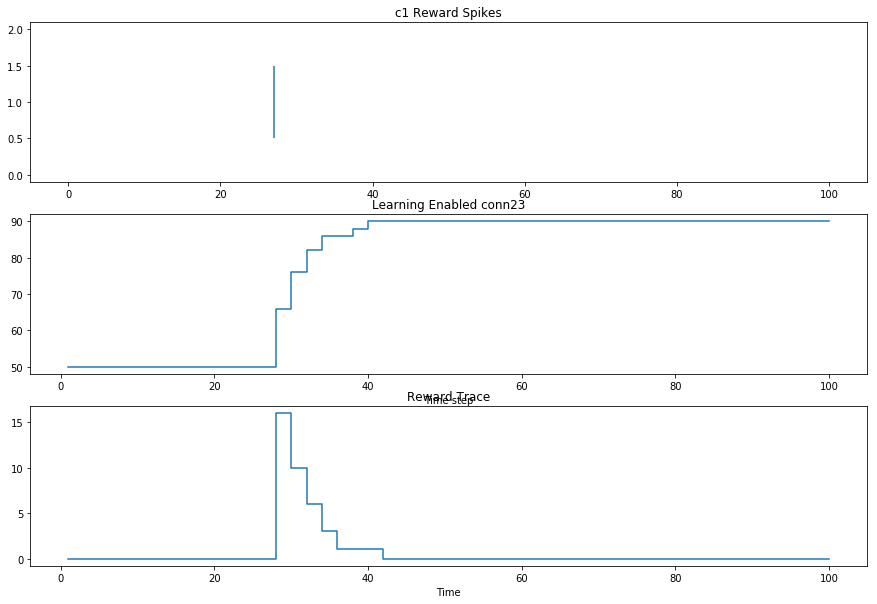

In [10]:
fig1 = plt.figure(1, figsize=(15,10))
plt.subplot(3,1,1)
plt.xlim([-5,105])
c1Probes[0].plot()
plt.title('c1 Reward Spikes')
plt.subplot(3, 1, 2)
conn23PrbSyn[0].plot()
plt.title('Learning Enabled conn23')
plt.subplot(3, 1, 3)
rewardProbe[0].plot()
plt.title('Reward Trace')
plt.xlabel('Time')
plt.show()

.. code-links:: python clear